# **ML Regression Project - Energy Consumption Forecasting** https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption 

### Scope: Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years (Individual Household Electric Power Consumption)

## Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import datetime
from scipy.stats import norm

### Energy Consumption Class
- Creating an **Energy Consumption Forecasting Class** with descriptively named **Methods** to Load, Explore and Transform the Data into a suitable format for Modeling and Prediction
- The respective **Methods** will be called through an instance of the Class to perform their specific functions on the data under descriptive titles below

In [2]:
class Energy_Consumption_Forecasting():

    def __init__(self):
        self.InputTextFile = "C:/Users/manyo/OneDrive/Desktop/Integrify Academy/ML Projects/Household Energy Consumption/Household Power Consumption.txt"
        self.OutputCSV = "C:/Users/manyo/OneDrive/Desktop/Integrify Academy/ML Projects/Household Energy Consumption/Household_Power_Consumption.csv"
        self.df = self.LoadConvertText_ToCSV(self.InputTextFile, self.OutputCSV)
        self.Transformed_df = self.Transform_Dataframe()
        # self.TransformedDF_Copy = self.Transformed_df.copy()
#-----------------------------------------------------------------------------------------------         
    def LoadConvertText_ToCSV(self, path, output_file, delimiter=';'):
            self.df = pd.read_csv(path, delimiter=delimiter)
            self.df.to_csv(output_file, index=False)
            return self.df
#-----------------------------------------------------------------------------------------------  
    def Transform_Dataframe(self):
        
        #Copy of original Dataframe,Date and Time Columns to datetime data types
        self.Transformed_df = self.df.copy() 
        self.Transformed_df['Date'] = pd.to_datetime(self.Transformed_df['Date'], format='%d/%m/%Y', dayfirst=True, errors='coerce')  
        self.Transformed_df['Time'] = pd.to_datetime(self.Transformed_df['Time'], format='%H:%M:%S', errors='coerce') 
        
        #Extracting the Time component from 'Time' Column,'Month' and 'Year' from 'Date' Column
        self.Transformed_df['Time'] = self.Transformed_df['Time'].apply(lambda x: x.time())
        self.Transformed_df['Month'] = pd.to_datetime(self.Transformed_df.iloc[:, 0], dayfirst=True, errors='coerce').dt.month.astype(int)
        self.Transformed_df['Year'] = pd.to_datetime(self.Transformed_df.iloc[:, 0], dayfirst=True, errors='coerce').dt.year.astype(int)

        # Converting Non-numeric values to NaN and Columns 3 to 8 to Float Type
        for col in self.Transformed_df.columns[2:9]:
            self.Transformed_df[col] = pd.to_numeric(self.Transformed_df[col], errors='coerce')
            self.Transformed_df[col] = self.Transformed_df[col].astype(float)

        # Missing values and Index dropped
        self.Transformed_df = self.Transformed_df.dropna()
        self.Transformed_df.reset_index(drop=True, inplace=True)
        
        return self.Transformed_df
#-----------------------------------------------------------------------------------------------
    def Statistics_Dispersion(self):
        print("\033[1m\nDescriptive Statistics:\033[0m") 
        print(self.Transformed_df.info()) 
        print("\033[1m\nDispersion Measures:\033[0m") 
        display(self.Transformed_df.describe())
#-----------------------------------------------------------------------------------------------
    def Feature_Importance(self, TargetColumn ='Global_active_power', n_estimators=100):
    
        # Creating a Copy of the original DataFrame to avoid conflicts
        self.TransformedDF_Copy = self.Transformed_df.copy()

        # Dropping Columns Constituting the Target to Prevent Momorization by the Model Instead of Learning
        DropColumns = ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
        self.TransformedDF_Copy.drop(columns=DropColumns, inplace=True)
                   
        # Converting 'Date' Column to datetime dtype,Time'and 'Date' Columns to Formatted Strings
        self.TransformedDF_Copy['Date'] = pd.to_datetime(self.TransformedDF_Copy['Date'])
        self.TransformedDF_Copy['Time'] = self.TransformedDF_Copy['Time'].apply(lambda x: x.strftime('%H:%M:%S'))
        self.TransformedDF_Copy['Date'] = self.TransformedDF_Copy['Date'].dt.strftime('%Y-%m-%d')
    
        # Concatenating 'Date' and 'Time' Columns, then Converting to datetime
        self.TransformedDF_Copy['DateTime'] = pd.to_datetime(self.TransformedDF_Copy['Date'] + ' ' + self.TransformedDF_Copy['Time'])
    
        # Converting 'DateTime' Column to UNIX Timestamp (int64) and Droping 'Date' and 'Time' Columns
        self.TransformedDF_Copy['DateTime'] = self.TransformedDF_Copy['DateTime'].astype(np.int64)
        self.TransformedDF_Copy.drop(columns=['Date', 'Time'], inplace=True)

        # Excluding the Target Column from Features
        X = self.TransformedDF_Copy.drop(columns=[TargetColumn]) 
        y = self.TransformedDF_Copy[TargetColumn]
      
        # Initializing & Fitting LightGBM Regressor to Obtain Feature Importance
        LGB_Model = lgb.LGBMRegressor(n_estimators=n_estimators, random_state=42)
        LGB_Model.fit(X, y)
        
        # Extracting Feature Importance
        FeatureImportance = pd.DataFrame({'Feature': X.columns, 'Importance': LGB_Model.feature_importances_})
        FeatureImportance = FeatureImportance.sort_values(by='Importance', ascending=False)
    
        print("\033[1mFeature Importance:\033[0m")
        display(FeatureImportance)
        
        # Selecting Features with Importance Greater than the Threshold Value
        SelectedFeatures = FeatureImportance[FeatureImportance['Importance'] > 0.5]['Feature'].tolist()
              
        return SelectedFeatures
#-----------------------------------------------------------------------------------------------
    def TrainTest_Models(self, TargetColumn='Global_active_power'):
        
        SelectedFeatures = self.Feature_Importance()# Previous Method
    
        # Extracting Features and Target:
        X=self.TransformedDF_Copy[SelectedFeatures]
        y=self.TransformedDF_Copy[TargetColumn]
        
        # Standard Scaling and Splitting
        X_scaled = StandardScaler().fit_transform(X) 
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
        # Initializing the Models to be used:
        Models = {
            'Linear Regression': LinearRegression(),
            'Random Forest': RandomForestRegressor(random_state=42),
            'Gradient Boosting': GradientBoostingRegressor(random_state=42),
            'Decision Tree': DecisionTreeRegressor(random_state=42),
            #'Support Vector Regression': SVR() #VERY SLOW
            }
        # Training the Models:
        ModelPerformance = {}
        Predictions = {}
        
        for Model_Name, Model in Models.items():
            Model.fit(X_train, y_train)
            y_pred = Model.predict(X_test)
            Predictions[Model_Name] = y_pred # Storing the predictions
            
            # Evaluating the Models:
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            ModelPerformance[Model_Name] = {'Mean Squared Error': mse, 'R-squared': r2}
    
            # Model Reports:
            print(f"\033[1m{Model_Name}:\033[0m")
            print(f"Mean Squared Error: {mse}")
            print(f"R-squared: {r2}\n")
            #print(f"R-squared: {r2:.2f}%\n")  # R-squared as percentage with two decimal places
    
        return ModelPerformance,Predictions
#-----------------------------------------------------------------------------------------------
    def RegressionScatter_Plot(self, y_test, Predictions):
        plt.figure(figsize=(12, 8))
        plt.scatter(y_test, Predictions['Linear Regression'], label='Linear Regression', alpha=0.7)
        plt.scatter(y_test, Predictions['Random Forest'], label='Random Forest', alpha=0.7)
        plt.scatter(y_test, Predictions['Gradient Boosting'], label='Gradient Boosting', alpha=0.7)
        #plt.scatter(y_test, Predictions['Support Vector Regression'], label='Support Vector Regression', alpha=0.7)
        plt.scatter(y_test, Predictions['Decision Tree'], label='Decision Tree', alpha=0.7)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Perfect Fit')
        plt.xlabel('True Values')
        plt.ylabel('Predicted Values')
        plt.title('Regression Scatter Plot for Multiple Models')
        plt.legend()
        plt.grid(True)
        plt.show()
#-----------------------------------------------------------------------------------------------        
ECF = Energy_Consumption_Forecasting()

C:\Users\manyo\AppData\Local\Temp\ipykernel_35436\1844621243.py:11: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(path, delimiter=delimiter)


### 1.Downloading and Converting the Text File to CSV

In [3]:
ECF.LoadConvertText_ToCSV(ECF.InputTextFile,ECF.OutputCSV)

C:\Users\manyo\AppData\Local\Temp\ipykernel_35436\1844621243.py:11: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(path, delimiter=delimiter)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0


### 2.Description of Features

- 1.**Date:** Date in format dd/mm/yyyy
- 2.**Time:** time in format hh:mm:ss
- 3.**Global_active_power:** household global minute-averaged active power (in kilowatts),responsible for doing the actual work, such as turning motors, heating elements, or lighting bulbs.Represents the total consumption in one household unit. This is the **Target Column**
- 4.**Global_reactive_power:** household global minute-averaged reactive power (in kilovolt-amperes(kVAR)).Its the power that oscillates back and forth between the source and the load without being consumed, and is necessary for magnetizing inductive loads and maintaining voltage levels. It does not perform useful work but is essential for the proper functioning of electrical equipment.
- 5.**Voltage:** minute-averaged voltage (in volt)
- 6.**Global_intensity:** household global minute-averaged current intensity (in ampere)
- 7.**Sub_metering_1:** energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an -  oven and a microwave (hot plates are not electric but gas powered).
- 8.**Sub_metering_2:** energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
- 9.**Sub_metering_3:** energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

### 3.Missing Values in the Original Dataframe

In [4]:
MissingValues = ECF.df.isnull().sum()
print(MissingValues)

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64


### 4.Transforming the Dataframe 
- Changing columns to the correct datatypes
- Adding Month and Year Columns 
- Dropping Rows with Missing Values

In [5]:
ECF.Transform_Dataframe()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Month,Year
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,12,2006
1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,12,2006
2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,12,2006
3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,12,2006
4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,12,2006
...,...,...,...,...,...,...,...,...,...,...,...
2049275,2010-11-26,20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0,11,2010
2049276,2010-11-26,20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0,11,2010
2049277,2010-11-26,21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0,11,2010
2049278,2010-11-26,21:01:00,0.934,0.000,239.70,3.8,0.0,0.0,0.0,11,2010


### 5.Statistics and Dispersion Measures

In [6]:
ECF.Statistics_Dispersion()


Descriptive Statistics:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049280 entries, 0 to 2049279
Data columns (total 11 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Date                   datetime64[ns]
 1   Time                   object        
 2   Global_active_power    float64       
 3   Global_reactive_power  float64       
 4   Voltage                float64       
 5   Global_intensity       float64       
 6   Sub_metering_1         float64       
 7   Sub_metering_2         float64       
 8   Sub_metering_3         float64       
 9   Month                  int32         
 10  Year                   int32         
dtypes: datetime64[ns](1), float64(7), int32(2), object(1)
memory usage: 156.3+ MB
None

Dispersion Measures:


,Date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Month,Year
count,2049280,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,2008-12-01 13:00:00.309181952,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00,6.454433e+00,2.008425e+03
min,2006-12-16 00:00:00,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.006000e+03
25%,2007-12-10 00:00:00,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,2.007000e+03
50%,2008-11-30 00:00:00,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00,6.000000e+00,2.008000e+03
75%,2009-11-23 00:00:00,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,9.000000e+00,2.009000e+03
max,2010-11-26 00:00:00,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01,1.200000e+01,2.010000e+03
std,NaN,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00,3.423209e+00,1.124388e+00


# Some Insightful Consumption Trends

## 6. Consumption Distribution

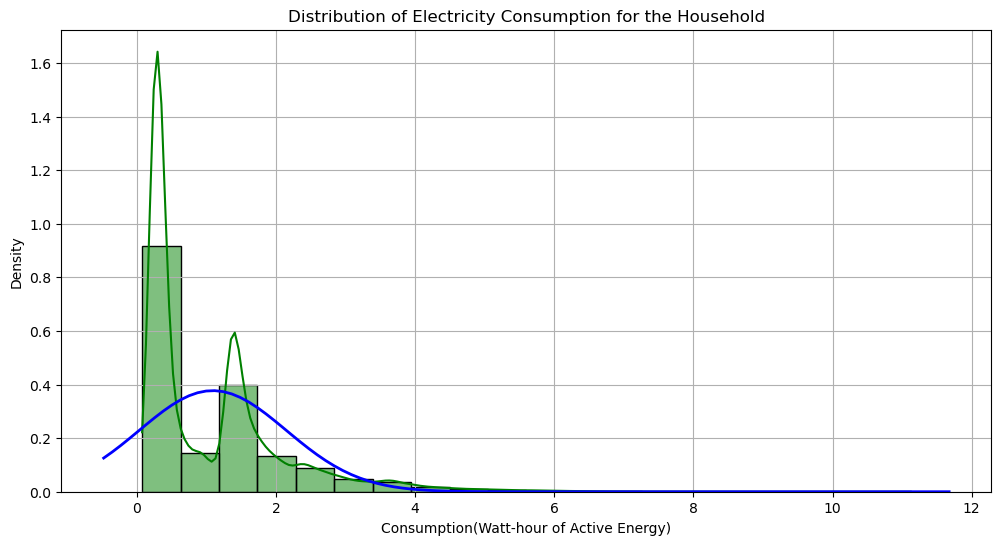

In [7]:
# Distribution Histogram
Consumption_Data = ECF.Transformed_df['Global_active_power']
plt.figure(figsize=(12, 6))
sns.histplot(Consumption_Data, kde=True, stat="density", color="green", bins=20)
# plt.gca().set_facecolor('#D3D3D3') #Background color

# Fitting a Normal Distribution to the Data
mu, std = norm.fit(Consumption_Data)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

# Overlaying the fitted Normal Distribution
plt.plot(x, p, color='blue', linewidth=2)

# Labels and Title
plt.grid(True)
plt.xlabel('Consumption(Watt-hour of Active Energy)')
plt.ylabel('Density')
plt.title('Distribution of Electricity Consumption for the Household')
plt.show()

### 8.Hourly Consumption Comparison for the 4 years using a Bar Plot

#### To obtain Hourly consumption, I proceed as follows:
- 1.Convert 'Time' column to strings then to datetime format
- 2.Combine 'Date' and 'Time' columns into a single Datetime Column
- 3.Extract the hour component for the 'Hour' Column
- 4.Drop the 'Datetime' Column because its no longer needed once the 'Hour' Column is in place

C:\Users\manyo\AppData\Local\Temp\ipykernel_35436\3390144181.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ECF.Transformed_df['Time'] = pd.to_datetime(ECF.Transformed_df['Time'])


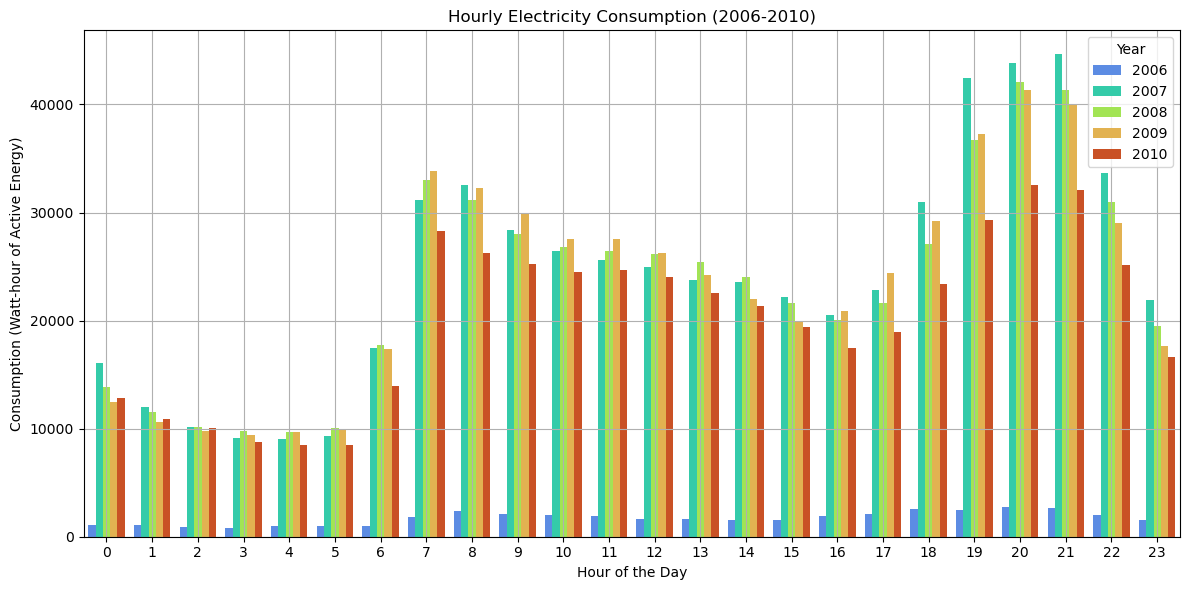

In [8]:
# Converting 'Time' Column first to strings then to datetime format
ECF.Transformed_df['Time'] = ECF.Transformed_df['Time'].astype(str)
ECF.Transformed_df['Time'] = pd.to_datetime(ECF.Transformed_df['Time'])

# Combining the 'Date' and 'Time' Columns
ECF.Transformed_df['Datetime'] = ECF.Transformed_df['Date'] + pd.to_timedelta(ECF.Transformed_df['Time'].dt.strftime('%H:%M:%S'))

# Extracting the Hour component
ECF.Transformed_df['Hour'] = ECF.Transformed_df['Datetime'].dt.hour

# Dropping the 'Datetime' Column 
ECF.Transformed_df.drop(columns=['Datetime'], inplace=True)

#Grouping the data by 'Year' and 'Hour' and calculating the Sum of 'Global_active_power':
Hourly_Consumption = ECF.Transformed_df.groupby(['Year', 'Hour'])['Global_active_power'].sum().reset_index()

# Plotting the Bar Graph
plt.figure(figsize=(12, 6))
sns.barplot(data=Hourly_Consumption, x='Hour', y='Global_active_power', hue='Year', palette='turbo')
plt.title('Hourly Electricity Consumption (2006-2010)')
plt.xlabel('Hour of the Day')
plt.ylabel('Consumption (Watt-hour of Active Energy)')
plt.legend(title='Year')
plt.grid(True)
plt.tight_layout()
plt.show()

### 9.Monthly Consumption Comparison for the 4 years using Line Plot

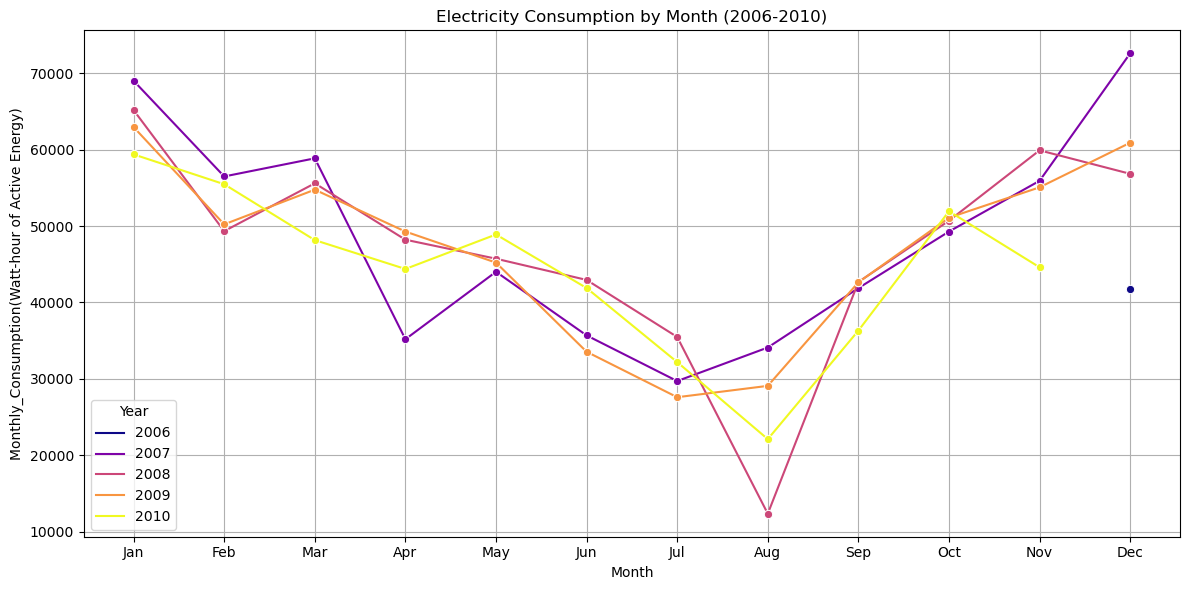

In [9]:
#Aggregating the data by Year and Month
Monthly_Consumption = ECF.Transformed_df.groupby(['Year', 'Month'])['Global_active_power'].sum().reset_index()

# Step 4: Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=Monthly_Consumption, x='Month', y='Global_active_power', hue='Year', marker='o',palette='plasma')
plt.title('Electricity Consumption by Month (2006-2010)')
plt.xlabel('Month')
plt.ylabel('Monthly_Consumption(Watt-hour of Active Energy)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.grid(True)
plt.tight_layout()
plt.show()

### 10.Monthly Consumption Comparison for the 4 years using Bar Plot

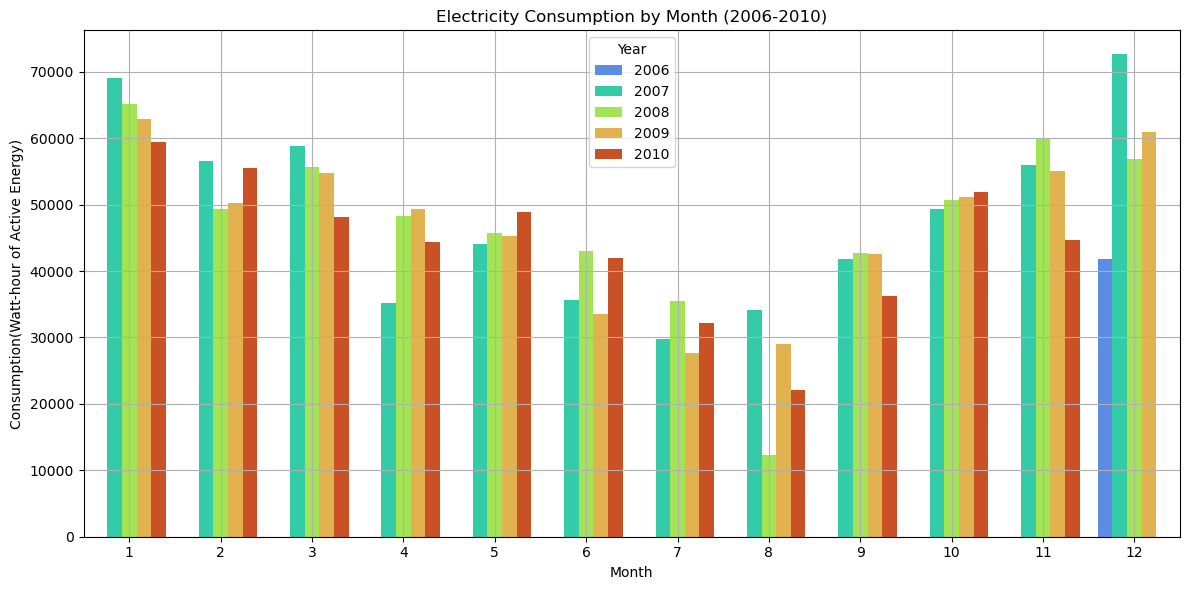

In [10]:
Monthly_Consumption2 = ECF.Transformed_df.groupby(['Year', 'Month'])['Global_active_power'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=Monthly_Consumption2, x='Month', y='Global_active_power', hue='Year', palette='turbo')
plt.title('Electricity Consumption by Month (2006-2010)')
plt.xlabel('Month')
plt.ylabel('Consumption(Watt-hour of Active Energy)')
#plt.xticks(rotation=45)
plt.legend(title='Year')
plt.grid(True)
plt.tight_layout()
plt.show()

### 11.Annual Consumption Comparison for the 4 years

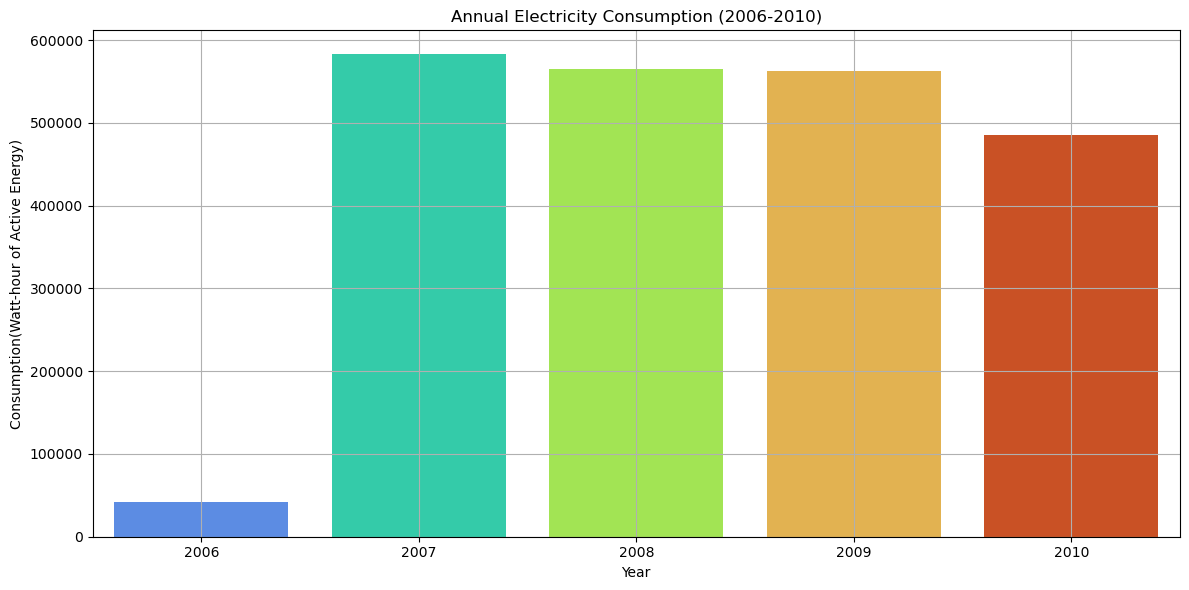

In [11]:
#Aggregating the data by Year
Annual_Consumption = ECF.Transformed_df.groupby('Year')['Global_active_power'].sum().reset_index() 

#Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=Annual_Consumption, x='Year', y='Global_active_power', palette='turbo')
plt.title('Annual Electricity Consumption (2006-2010)')
plt.xlabel('Year')
plt.ylabel('Consumption(Watt-hour of Active Energy)')
plt.grid(True)
plt.tight_layout()
plt.show()

## 12.Sub_Metering_1 (Kitchen Area) Consumption Trends

### Hourly Kitchen Consumption for 4 Years

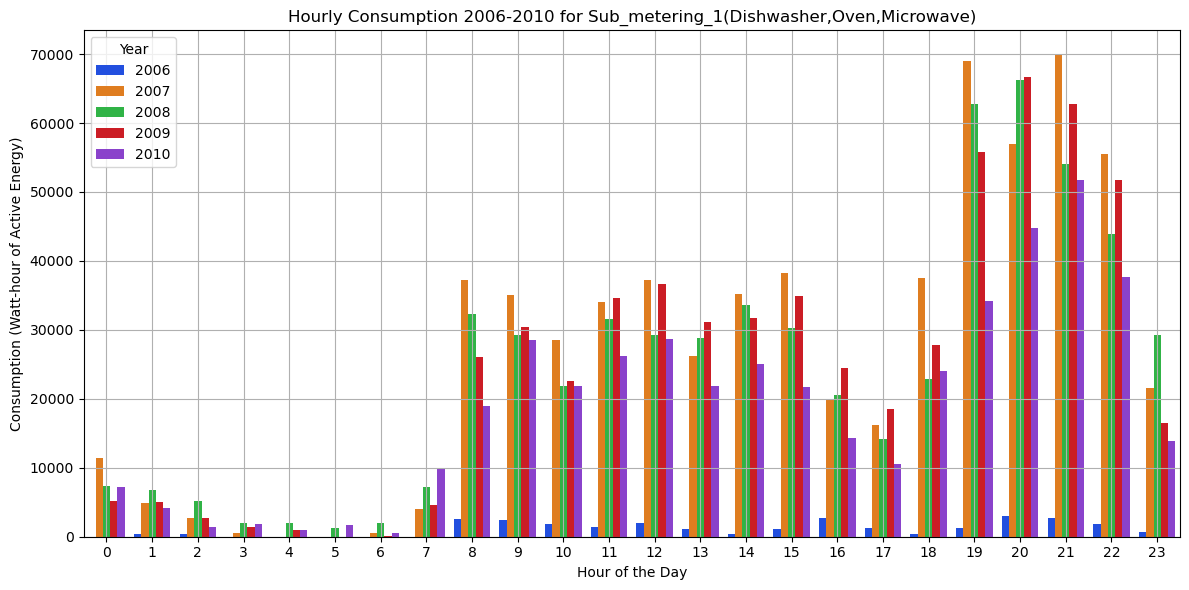

In [12]:
#Aggregating the data by 'Year' and 'Hour' and calculating the Sum of 'Sub_metering_1':
Hourly_KitchenConsumption = ECF.Transformed_df.groupby(['Year', 'Hour'])['Sub_metering_1'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=Hourly_KitchenConsumption, x='Hour', y='Sub_metering_1',hue='Year',palette='bright')
plt.title('Hourly Consumption 2006-2010 for Sub_metering_1(Dishwasher,Oven,Microwave)') 
plt.xlabel('Hour of the Day')
plt.ylabel('Consumption (Watt-hour of Active Energy)')
plt.legend(title='Year')
plt.grid(True)
plt.tight_layout()
plt.show()

### Monthly Kitchen Consumption for 4 Years

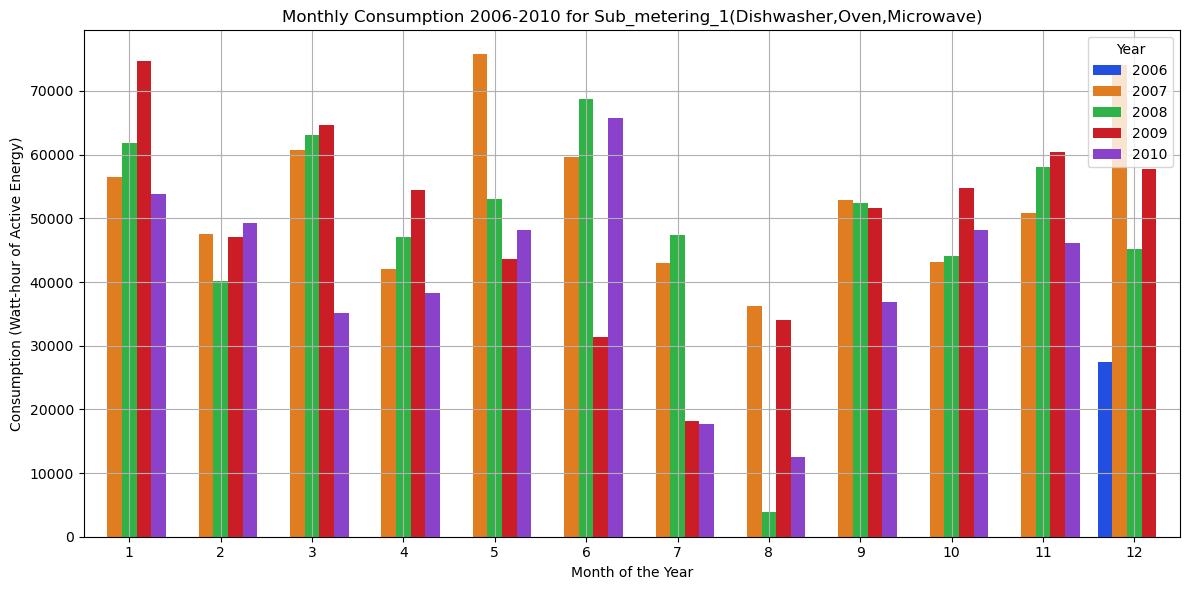

In [13]:
#Aggregating the data by 'Year' and 'Month' and calculating the Sum of 'Sub_metering_1':
Monthly_KitchenConsumption = ECF.Transformed_df.groupby(['Year', 'Month'])['Sub_metering_1'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=Monthly_KitchenConsumption, x='Month', y='Sub_metering_1',hue='Year',palette='bright')
plt.title('Monthly Consumption 2006-2010 for Sub_metering_1(Dishwasher,Oven,Microwave)') 
plt.xlabel('Month of the Year')
plt.ylabel('Consumption (Watt-hour of Active Energy)')
plt.legend(title='Year')
plt.grid(True)
plt.tight_layout()
plt.show()

### Annual Kithchen Consumption for 4 Years

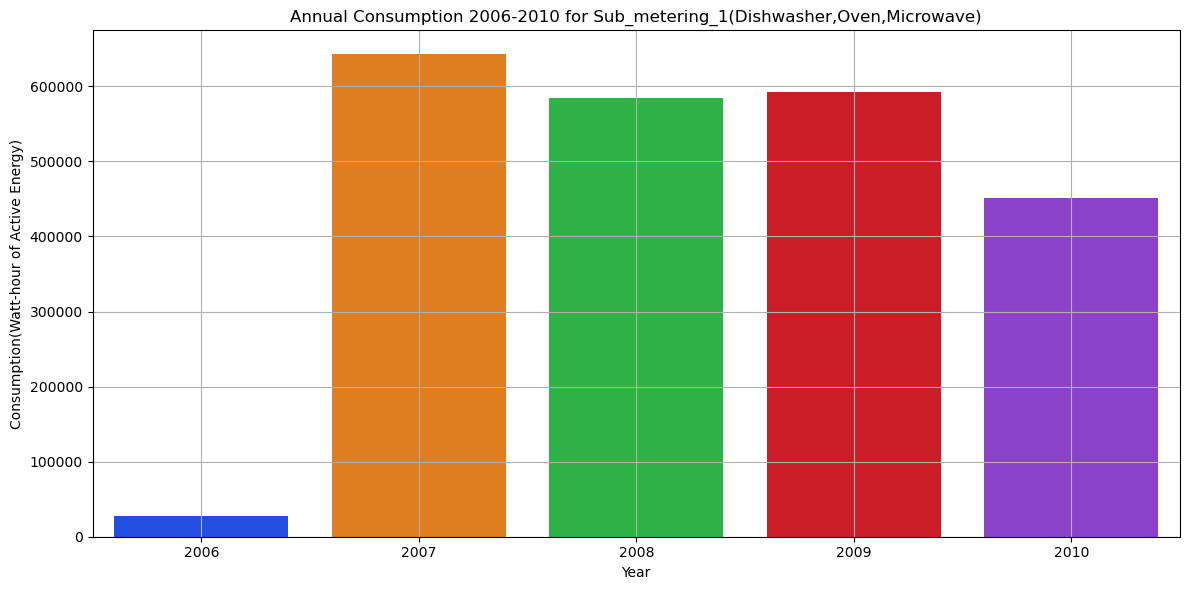

In [14]:
#Aggregating the data by Year
Annual_KitchenConsumption = ECF.Transformed_df.groupby('Year')['Sub_metering_1'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=Annual_KitchenConsumption, x='Year', y='Sub_metering_1', palette='bright')
plt.title('Annual Consumption 2006-2010 for Sub_metering_1(Dishwasher,Oven,Microwave)')
plt.xlabel('Year')
plt.ylabel('Consumption(Watt-hour of Active Energy)')
plt.grid(True)
plt.tight_layout()
plt.show()

## 13.Sub_Metering_2 (Laundry Room,Refrigerator,&Lighting) Consumption Trends

### Hourly Laundry Room,Refrigerator,and Lighting Consumption for 4 Years

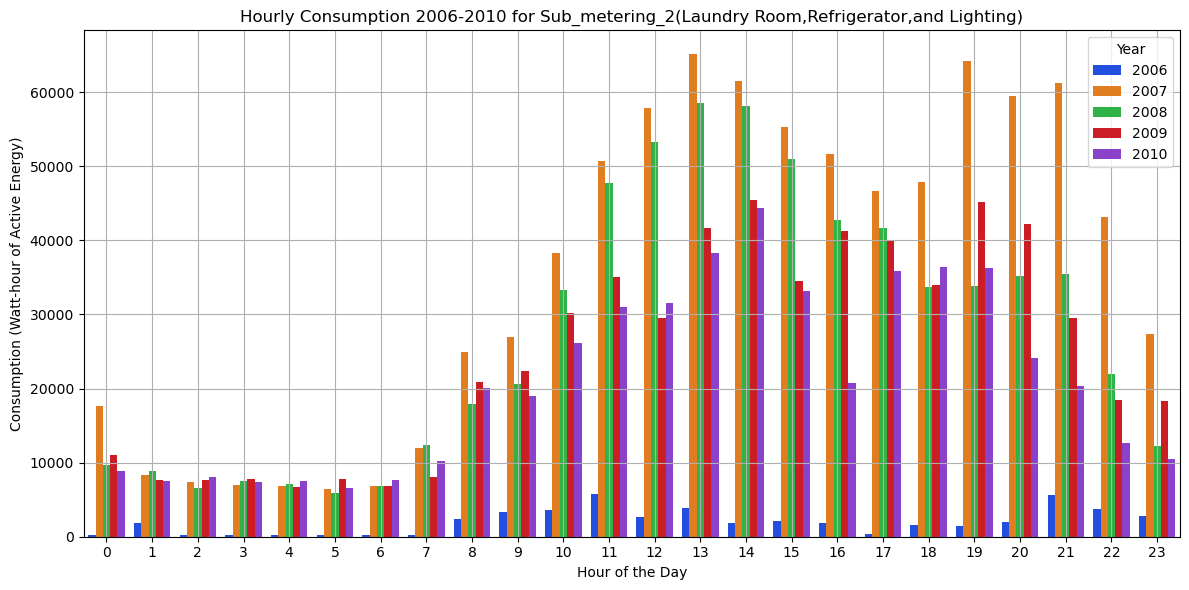

In [15]:
#Aggregating the data by 'Year' and 'Hour' and calculating the Sum of 'Sub_metering_2':
Hourly_LRLConsumption = ECF.Transformed_df.groupby(['Year', 'Hour'])['Sub_metering_2'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=Hourly_LRLConsumption, x='Hour', y='Sub_metering_2',hue='Year',palette='bright')
plt.title('Hourly Consumption 2006-2010 for Sub_metering_2(Laundry Room,Refrigerator,and Lighting)') 
plt.xlabel('Hour of the Day')
plt.ylabel('Consumption (Watt-hour of Active Energy)')
plt.legend(title='Year')
plt.grid(True)
plt.tight_layout()
plt.show()

### Monthly Laundry Room,Refrigerator,and Lighting Consumption for 4 Years

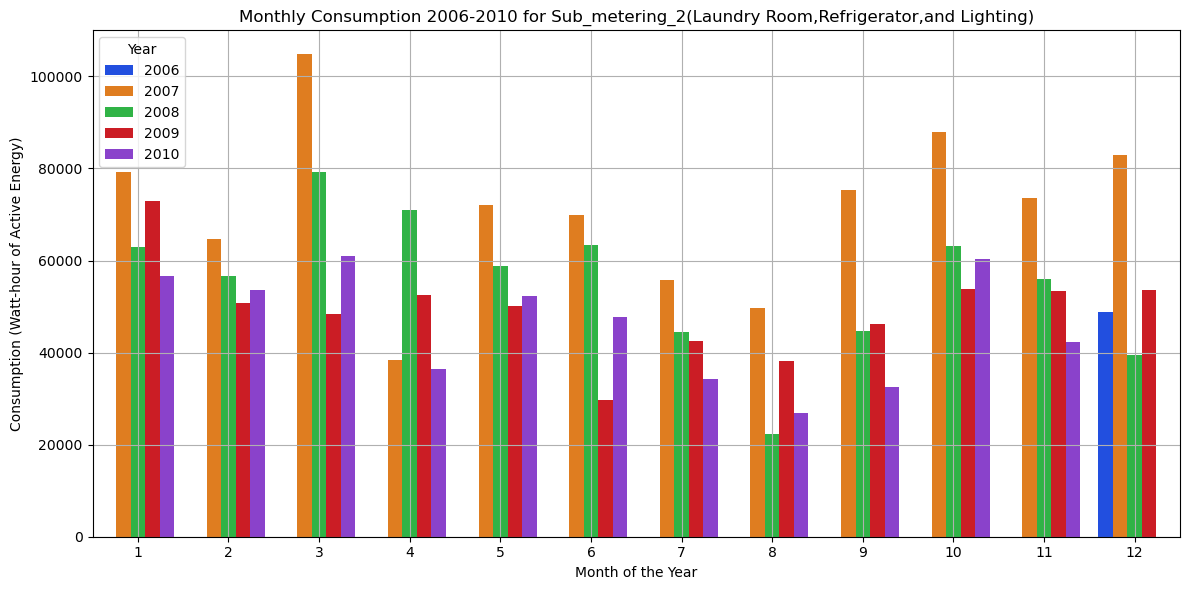

In [16]:
#Aggregating the data by 'Year' and 'Month' and calculating the Sum of 'Sub_metering_2':
Monthly_LRLConsumption = ECF.Transformed_df.groupby(['Year', 'Month'])['Sub_metering_2'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=Monthly_LRLConsumption, x='Month', y='Sub_metering_2',hue='Year',palette='bright')
plt.title('Monthly Consumption 2006-2010 for Sub_metering_2(Laundry Room,Refrigerator,and Lighting)') 
plt.xlabel('Month of the Year')
plt.ylabel('Consumption (Watt-hour of Active Energy)')
plt.legend(title='Year')
plt.grid(True)
plt.tight_layout()
plt.show()

### Annual Laundry Room,Refrigerator,and Lighting Consumption for 4 Years

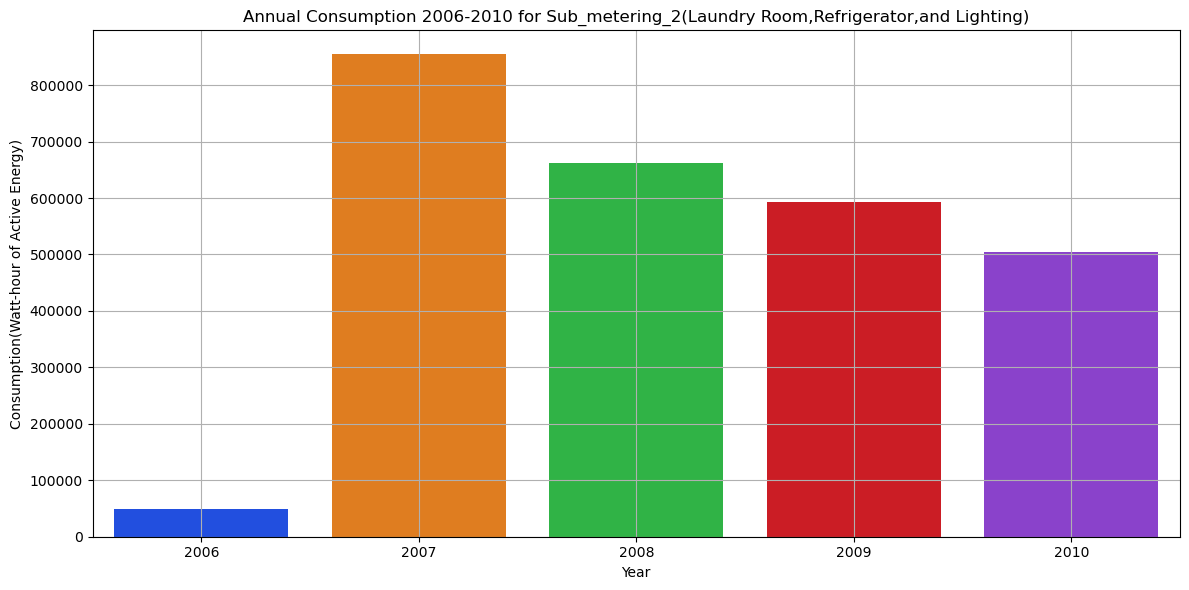

In [17]:
#Aggregating the data by Year
Annual_LRLConsumption = ECF.Transformed_df.groupby('Year')['Sub_metering_2'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=Annual_LRLConsumption, x='Year', y='Sub_metering_2', palette='bright')
plt.title('Annual Consumption 2006-2010 for Sub_metering_2(Laundry Room,Refrigerator,and Lighting)')
plt.xlabel('Year')
plt.ylabel('Consumption(Watt-hour of Active Energy)')
plt.grid(True)
plt.tight_layout()
plt.show()

### 14.Sub_Metering_3 Consumption Trends

### Hourly Water Heater and AC Consumption for 4 Years

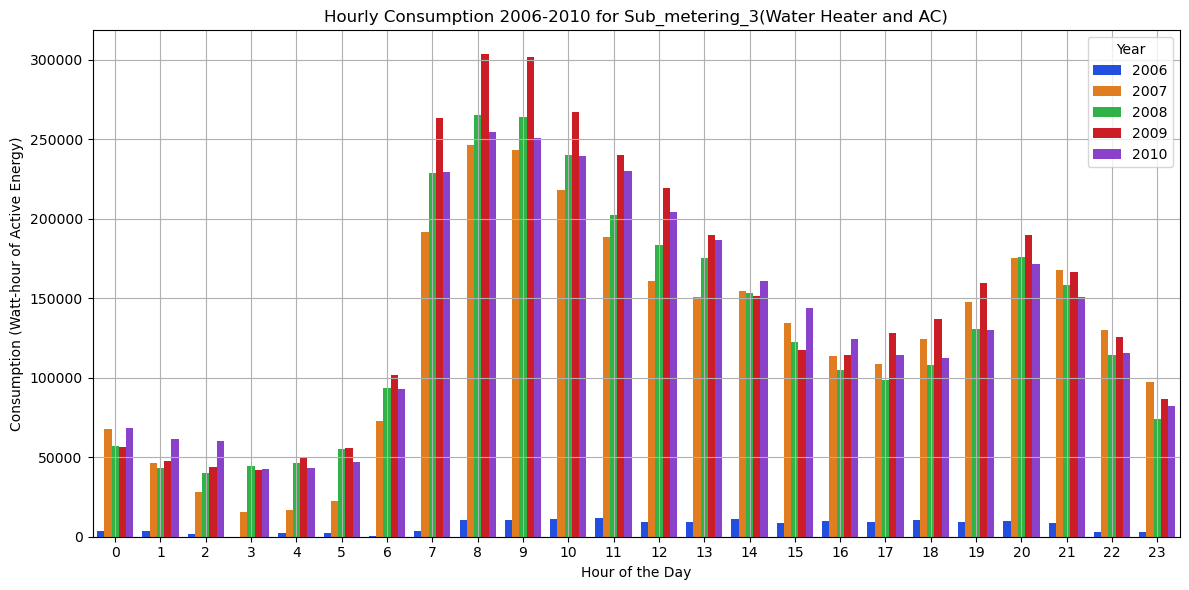

In [18]:
#Aggregating the data by 'Year' and 'Hour' and calculating the Sum of 'Sub_metering_3':
Hourly_WHACConsumption = ECF.Transformed_df.groupby(['Year', 'Hour'])['Sub_metering_3'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=Hourly_WHACConsumption, x='Hour', y='Sub_metering_3',hue='Year',palette='bright')
plt.title('Hourly Consumption 2006-2010 for Sub_metering_3(Water Heater and AC)') 
plt.xlabel('Hour of the Day')
plt.ylabel('Consumption (Watt-hour of Active Energy)')
plt.legend(title='Year')
plt.grid(True)
plt.tight_layout()
plt.show()

### Monthly Water Heater and AC Consumption for 4 Years

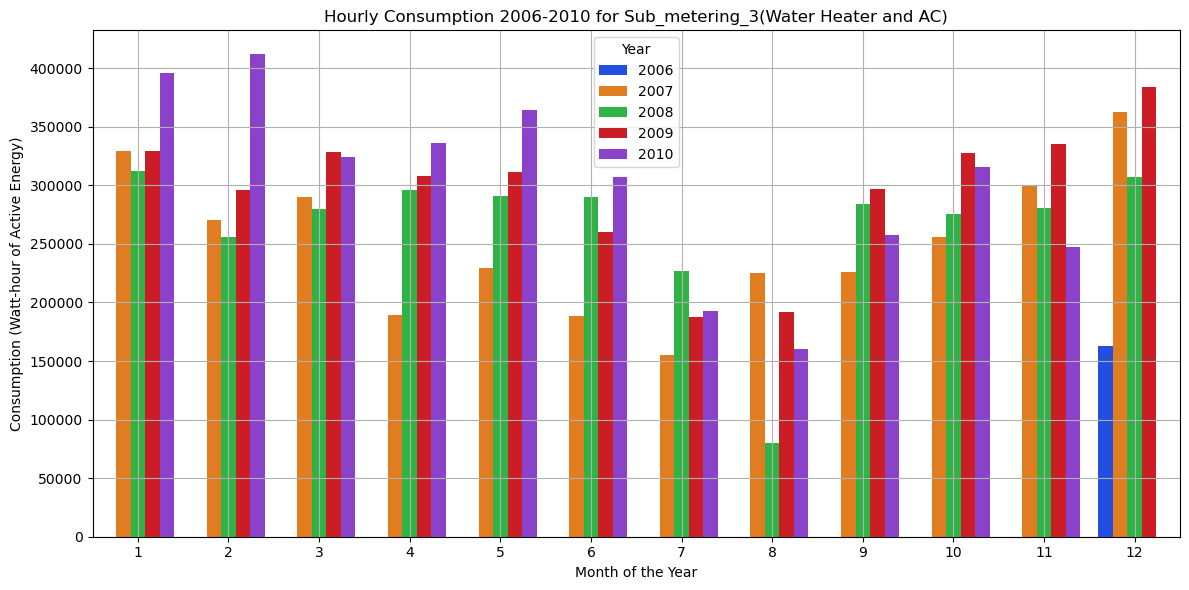

In [19]:
#Aggregating the data by 'Year' and 'Month' and calculating the Sum of 'Sub_metering_3':
Monthly_WHACConsumption = ECF.Transformed_df.groupby(['Year', 'Month'])['Sub_metering_3'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=Monthly_WHACConsumption, x='Month', y='Sub_metering_3',hue='Year',palette='bright')
plt.title('Hourly Consumption 2006-2010 for Sub_metering_3(Water Heater and AC)') 
plt.xlabel('Month of the Year')
plt.ylabel('Consumption (Watt-hour of Active Energy)')
plt.legend(title='Year')
plt.grid(True)
plt.tight_layout()
plt.show()

### Annual Water Heater and AC Consumption for 4 Years

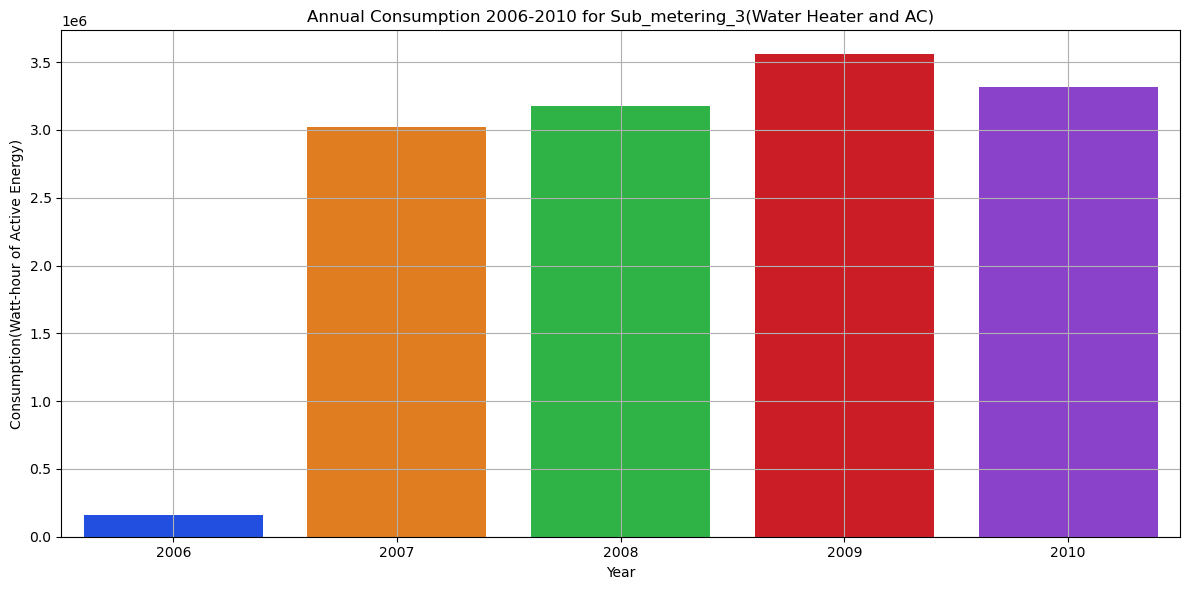

In [20]:
#Aggregating the data by Year
Annual_WHACConsumption = ECF.Transformed_df.groupby('Year')['Sub_metering_3'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=Annual_WHACConsumption, x='Year', y='Sub_metering_3', palette='bright')
# sns.lineplot(data=Annual_WHACConsumption, x='Year', y='Sub_metering_3', palette='bright', marker='o')
plt.title('Annual Consumption 2006-2010 for Sub_metering_3(Water Heater and AC)')
plt.xlabel('Year')
plt.ylabel('Consumption(Watt-hour of Active Energy)')
plt.grid(True)
plt.tight_layout()
plt.show()

### 8.Correlation Matrix

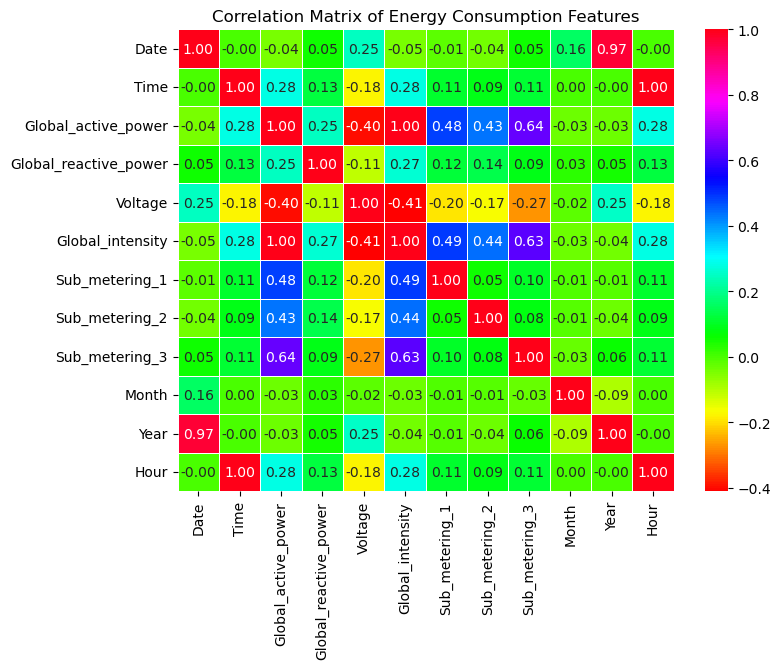

In [21]:
CM = ECF.Transformed_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(CM, annot=True, cmap='hsv', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix of Energy Consumption Features")
plt.show()

 - The correlation among features is low, so we proceed to use Feature Importance to determine the best feature hierarchy

### 9. Determining Feature Importance using Light Gradient Boosting Machine (LightGBM)

In [22]:
ECF.Feature_Importance()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 983
[LightGBM] [Info] Number of data points in the train set: 2049280, number of used features: 7
[LightGBM] [Info] Start training from score 1.091615
Feature Importance:


,Feature,Importance
2,Global_intensity,1290
1,Voltage,423
0,Global_reactive_power,417
6,DateTime,414
5,Hour,295
3,Month,144
4,Year,17


['Global_intensity',
 'Voltage',
 'Global_reactive_power',
 'DateTime',
 'Hour',
 'Month',
 'Year']

print(ECF.TransformedDF_Copy.columns)
print(ECF.TransformedDF_Copy.shape)

### 10.Model Training,Prediction, and Evaluation

In [23]:
ECF.TrainTest_Models()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 983
[LightGBM] [Info] Number of data points in the train set: 2049280, number of used features: 7
[LightGBM] [Info] Start training from score 1.091615
Feature Importance:


,Feature,Importance
2,Global_intensity,1290
1,Voltage,423
0,Global_reactive_power,417
6,DateTime,414
5,Hour,295
3,Month,144
4,Year,17


Linear Regression:
Mean Squared Error: 0.0018618431323507113
R-squared: 0.9983434726369105

Random Forest:
Mean Squared Error: 0.0009447218767996569
R-squared: 0.9991594578446295

Gradient Boosting:
Mean Squared Error: 0.0013787341656581436
R-squared: 0.9987733064981927

Decision Tree:
Mean Squared Error: 0.0017750316501405372
R-squared: 0.9984207109354615



({'Linear Regression': {'Mean Squared Error': 0.0018618431323507113,
   'R-squared': 0.9983434726369105},
  'Random Forest': {'Mean Squared Error': 0.0009447218767996569,
   'R-squared': 0.9991594578446295},
  'Gradient Boosting': {'Mean Squared Error': 0.0013787341656581436,
   'R-squared': 0.9987733064981927},
  'Decision Tree': {'Mean Squared Error': 0.0017750316501405372,
   'R-squared': 0.9984207109354615}},
 {'Linear Regression': array([1.52133991, 0.40336149, 0.66497336, ..., 0.25029519, 2.48421432,
         2.16358508]),
  'Random Forest': array([1.5135 , 0.37568, 0.64282, ..., 0.2637 , 2.52042, 2.06456]),
  'Gradient Boosting': array([1.54348036, 0.38613495, 0.64404545, ..., 0.23890904, 2.51689596,
         2.15548204]),
  'Decision Tree': array([1.506, 0.378, 0.646, ..., 0.262, 2.536, 2.204])})

- **Mean Squared Error (MSE)**: It measures the average squared difference between predicted and true values.
- **R-squared (R2)**: It indicates the proportion of the variance in the dependent variable that is predictable from the independent variables.

#### **To be Continued:**

- 1.Time Series Plot
- 2.Regression Scatter Plot
- 3.Residuals vs. Predicted Plot